In [1]:
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import tensorflow as tf
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip') 
DB_URI = f'postgresql://{os.environ["PG_USER"]}:{os.environ["PG_PASS"]}@{os.environ["PG_URL"]}/{os.environ["PG_DB"]}'
try:
    engine = sa.create_engine(DB_URI)
    with engine.connect() as connection:
        data = pd.read_sql_table(table_name='stocks_1m_price', con=connection)
        # data = pd.read_sql_table(table_name='tsocks_daily_price', con=connection)
        data['datetime'] = pd.to_datetime(data['datetime'])
        print(data.shape)
        print(data.info())
        print(data.head())
except Exception as e:
    print(e)
finally:
    if 'engine' in locals():
        engine.dispose()

(28466477, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28466477 entries, 0 to 28466476
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   symbol     object        
 1   datetime   datetime64[ns]
 2   adj_open   float64       
 3   adj_high   float64       
 4   adj_low    float64       
 5   adj_close  float64       
 6   volume     int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.5+ GB
None
  symbol            datetime  adj_open  adj_high  adj_low  adj_close  volume
0      A 2024-07-15 07:07:00   132.250   132.250  132.230    132.230       5
1      A 2024-07-15 07:11:00   132.250   132.250  132.180    132.230       6
2      A 2024-07-15 07:40:00   132.010   132.010  131.380    131.380       5
3      A 2024-07-15 08:00:00   133.312   133.312  133.312    133.312      10
4      A 2024-07-15 08:02:00   132.230   132.230  132.230    132.230       1


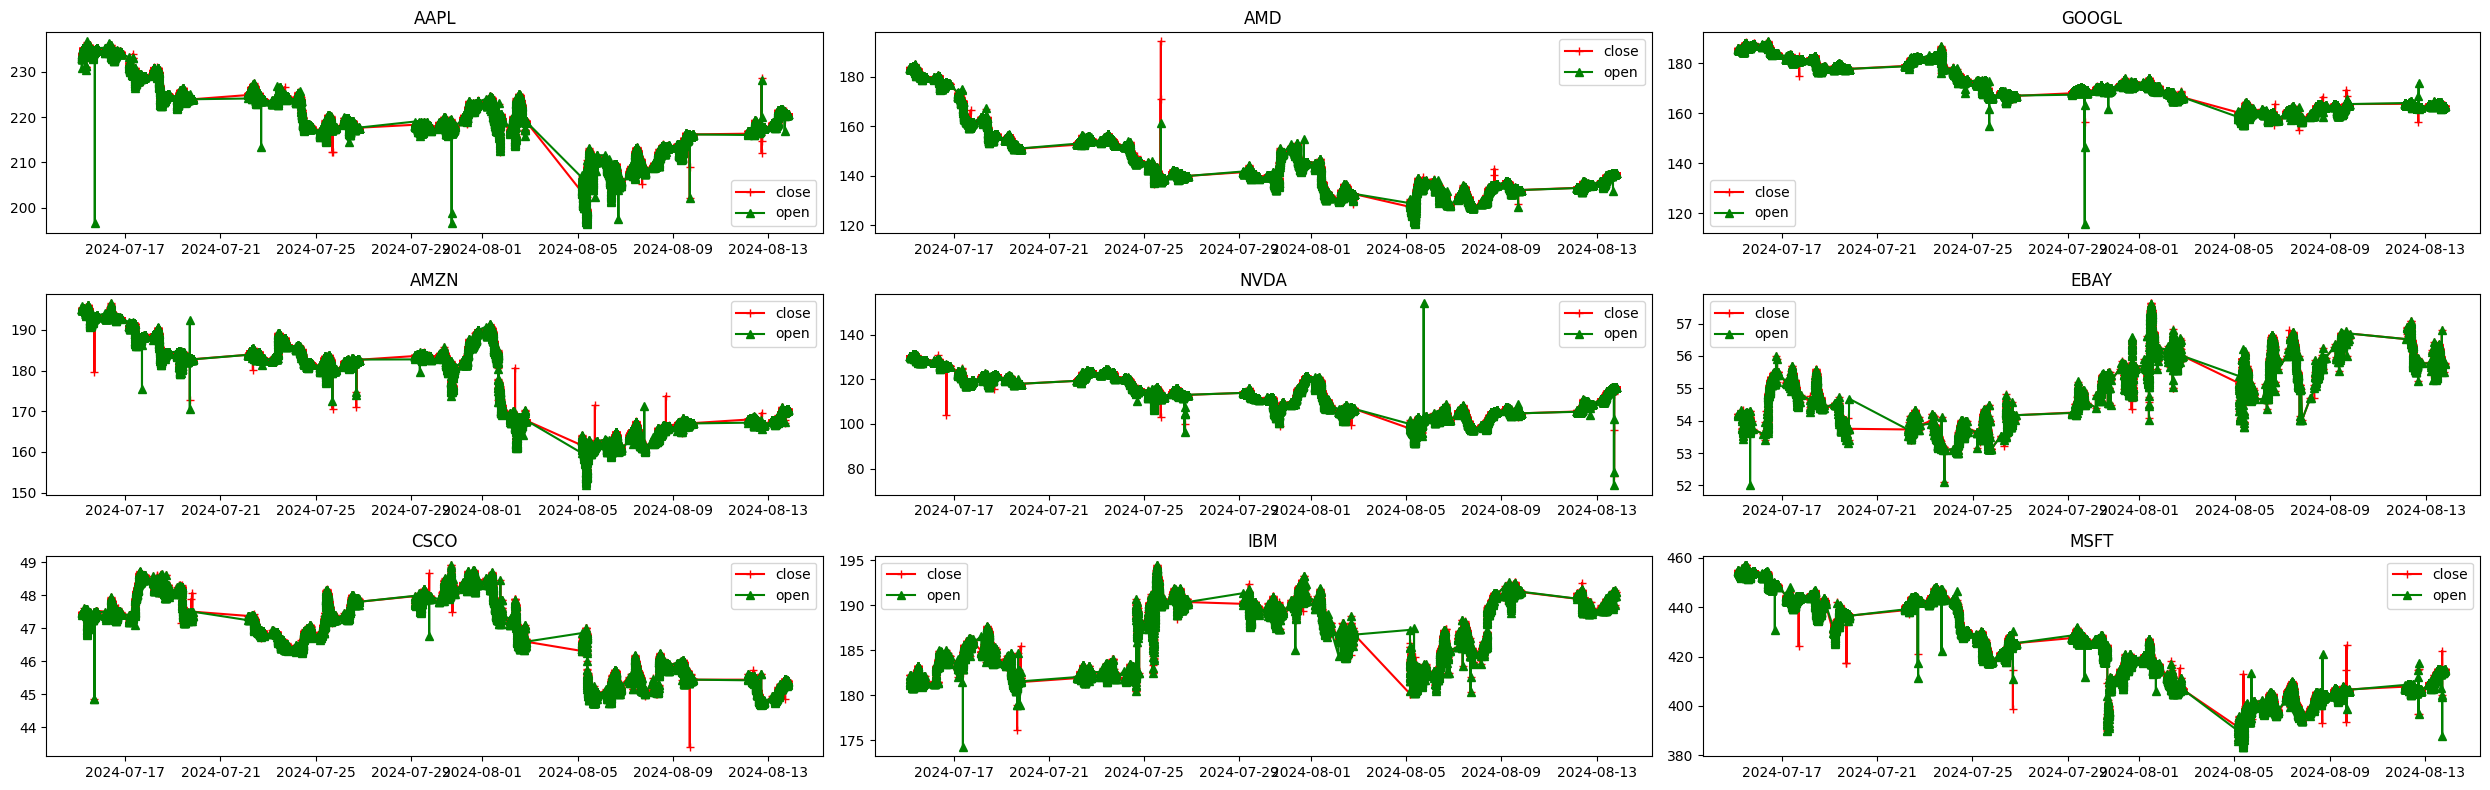

In [3]:
# Define the list of companies you want to plot
companies = ['AAPL', 'AMD', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM', 'MSFT']

# PLot the open and close prices of the stocks
plt.figure(figsize=(25, 8)) 
for index, company in enumerate(companies, 1): 
    plt.subplot(3, 3, index) 
    c = data[data['symbol'] == company] 
    plt.plot(c['datetime'], c['adj_close'], c="r", label="close", marker="+") 
    plt.plot(c['datetime'], c['adj_open'], c="g", label="open", marker="^") 
    plt.title(company) 
    plt.legend() 
    plt.tight_layout()

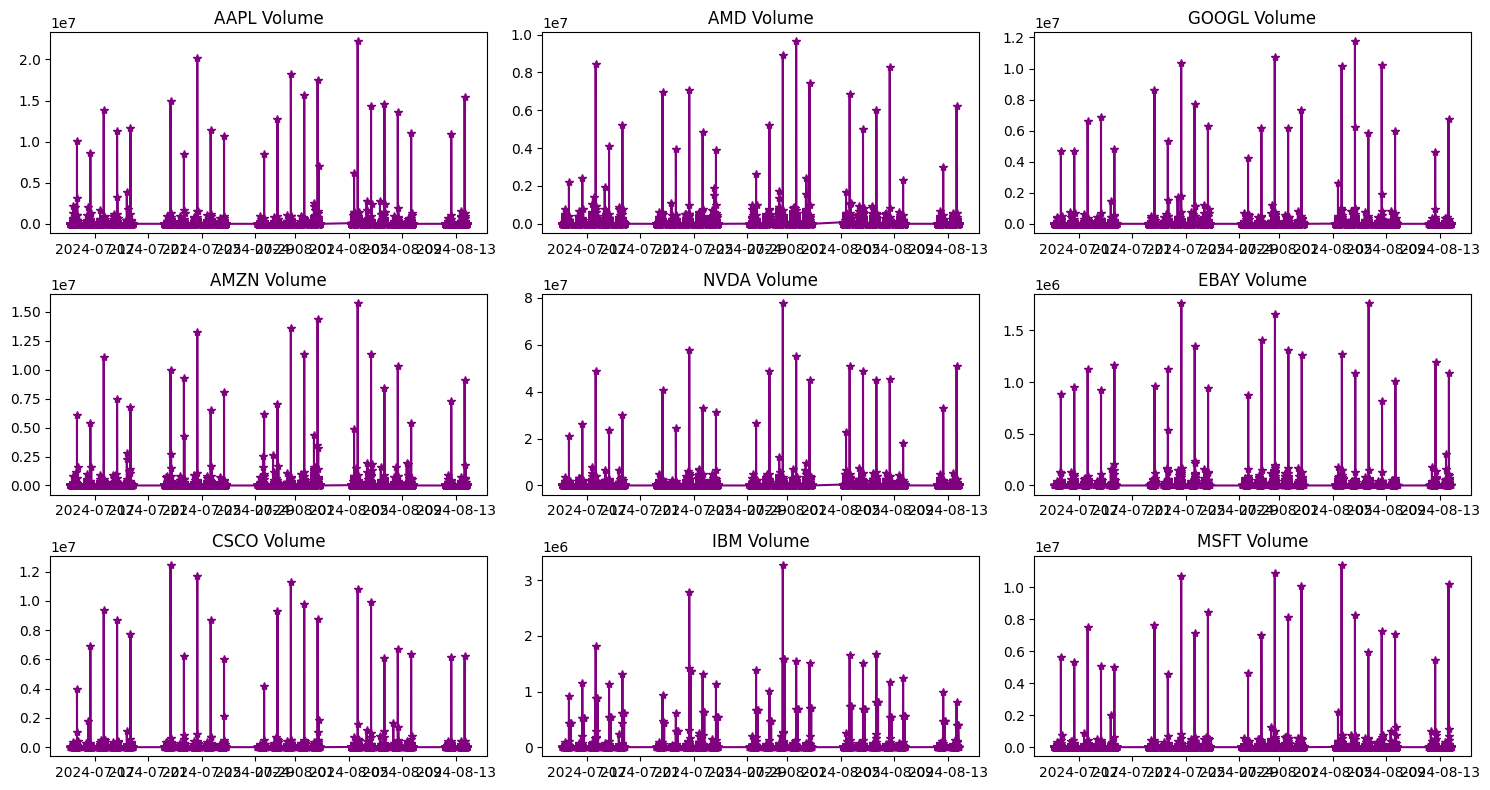

In [4]:
# Volume as a function of time
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['symbol'] == company]
    plt.plot(c['datetime'], c['volume'], c='purple', marker='*')
    plt.title(f"{company} Volume")
    plt.tight_layout()

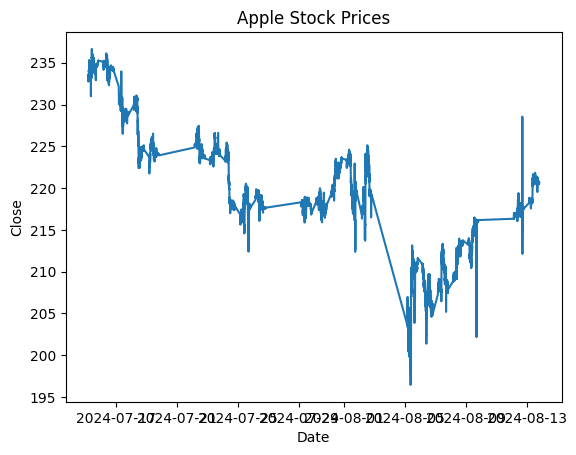

In [5]:
# Plot the adjusted close price of Apple
apple = data[data['symbol'] == 'AAPL']
prediction_range = apple.loc[(apple['datetime'] > datetime(2013,1,1)) & (apple['datetime']<datetime(2018,1,1))]
plt.plot(apple['datetime'],apple['adj_close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [6]:
# Split the data into training and testing

close_data = apple.filter(['adj_close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

20032


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <Sequential name=sequential, built=True>>

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')
checkpoint_path = "stock_price.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    callbacks=[cp_callback])

Epoch 1/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014
Epoch 1: saving model to stock_price.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0014
Epoch 2/10
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013
Epoch 2: saving model to stock_price.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0013
Epoch 3/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013
Epoch 3: saving model to stock_price.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0013
Epoch 4/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014
Epoch 4: saving model to stock_price.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0014
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013
Epoch 5: saving model to stock_price.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0013
Epoch 6/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014
Epoch 6: saving model to stock_price.weights.h5
625/625 ━━━━━━

In [16]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE 0.015775231884626303
RMSE 0.1255994899855342


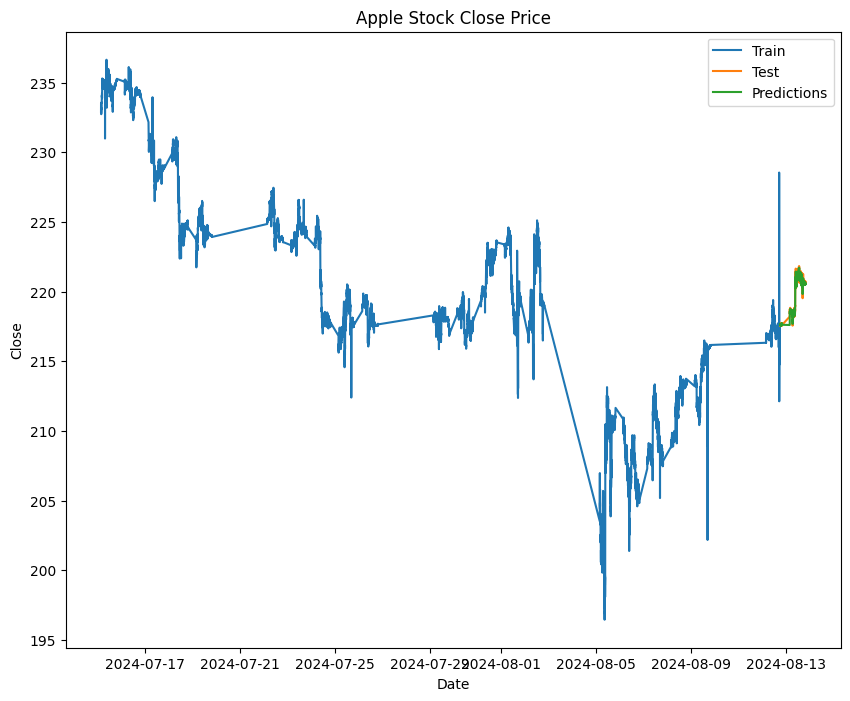

In [17]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['datetime'], train['adj_close'])
plt.plot(test['datetime'], test[['adj_close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])